# MODEL SETUP

In [1]:
import os
import sys
import json
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

#Import adaptions
from fashion_config import FashionConfig
from fashion_dataset import FashionDataset

%matplotlib inline

# Hide some tensorflaw warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vic/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

In [2]:
""" Load config """ 
config = FashionConfig()
#config.display()

In [3]:
""" Prepare dataset """ 
dataset_train = FashionDataset()
dataset_train.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "train")
dataset_train.prepare()

dataset_val = FashionDataset()
dataset_val.load_fashion(ROOT_DIR + '/datasets/big_deepfashion2', "val")
dataset_val.prepare()


In [4]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [5]:
# Load trained weights
model_path = "../logs/final_logs/logs_mask_rcnn_fashion_0045.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../logs/final_logs/logs_mask_rcnn_fashion_0045.h5


In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# EVALUATIONS


## Visual comparison between ground truth and model

Image #19667
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (26,)                 min:    0.00000  max: 19667.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    7.00000  uint8
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  605.00000  int32
gt_mask                  shape: (640, 640, 2)         min:    0.00000  max:    1.00000  uint8
gt_landmark              shape: (640, 640, 2)         min:    0.00000  max:    2.00000  float64


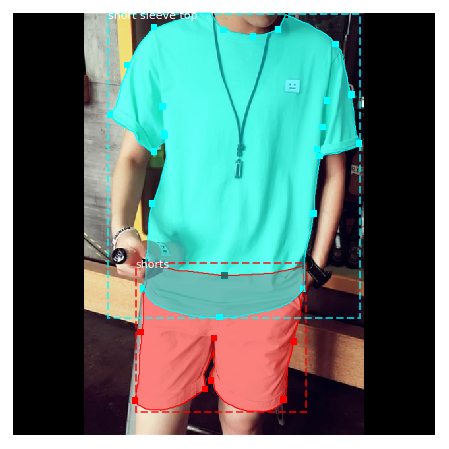

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


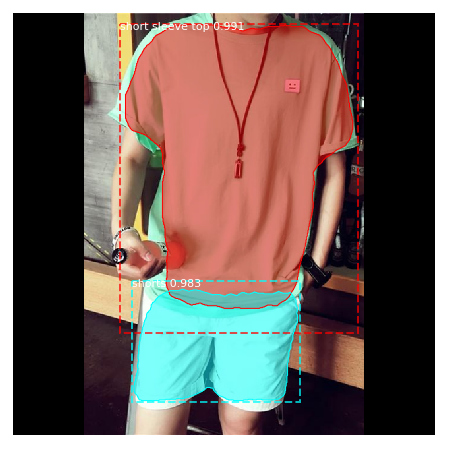

In [7]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

#Test on specific image
#image_id = 17803
#image_id = 7818
print("Image #{}".format(image_id))

image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_landmark =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
log("gt_landmark", gt_landmark)

visualize.display_instances(image, gt_bbox, gt_mask, gt_landmark, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

results = model.detect([image], verbose=2)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['landmarks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Precision-recall curve
* The X-axis is recall: Recall is High if the amount of False Negatives is Low
* The Y-axis is precision: Precision is High if the amount of False Positives is low.


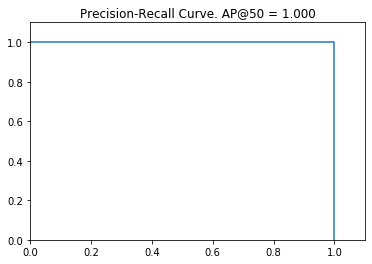

In [8]:
# Draw precision-recall curve based on what is returned in the image
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

## Heatmap of predictions and ground truth (Still in beta)

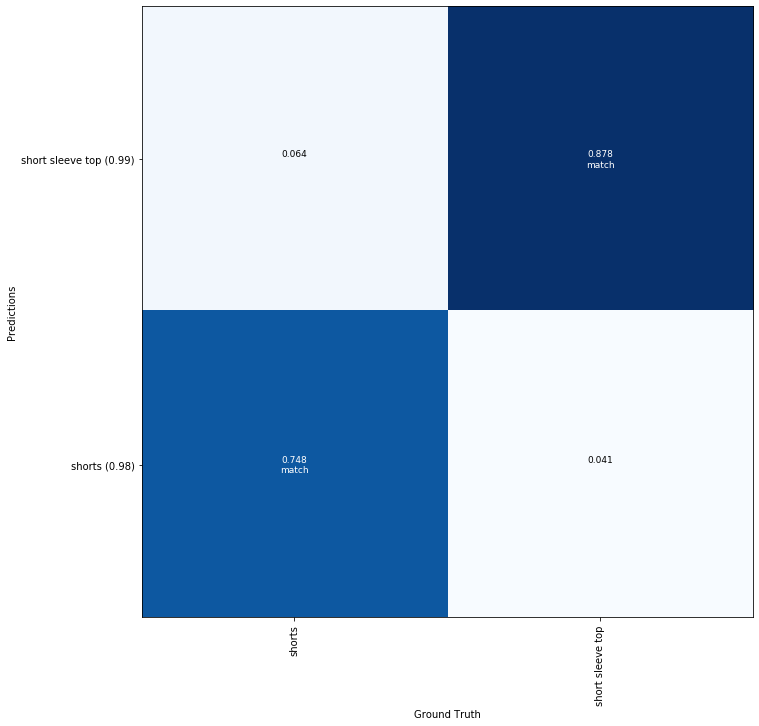

In [9]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

## Compare the generated masks
Useful to see what the network sees when there is overlap

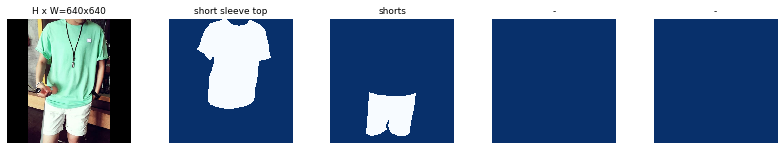

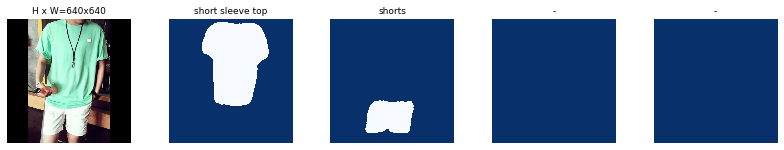

In [10]:
visualize.display_top_masks(image, gt_mask, gt_class_id, 
                            dataset_val.class_names)
visualize.display_top_masks(image, r['masks'], r['class_ids'], 
                            dataset_val.class_names)

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [11]:
#Check the names of all layers
for layer in model.keras_model.layers:
    print(layer.name)

input_image
zero_padding2d_1
conv1
bn_conv1
activation_1
max_pooling2d_1
res2a_branch2a
bn2a_branch2a
activation_2
res2a_branch2b
bn2a_branch2b
activation_3
res2a_branch2c
res2a_branch1
bn2a_branch2c
bn2a_branch1
add_1
res2a_out
res2b_branch2a
bn2b_branch2a
activation_4
res2b_branch2b
bn2b_branch2b
activation_5
res2b_branch2c
bn2b_branch2c
add_2
res2b_out
res2c_branch2a
bn2c_branch2a
activation_6
res2c_branch2b
bn2c_branch2b
activation_7
res2c_branch2c
bn2c_branch2c
add_3
res2c_out
res3a_branch2a
bn3a_branch2a
activation_8
res3a_branch2b
bn3a_branch2b
activation_9
res3a_branch2c
res3a_branch1
bn3a_branch2c
bn3a_branch1
add_4
res3a_out
res3b_branch2a
bn3b_branch2a
activation_10
res3b_branch2b
bn3b_branch2b
activation_11
res3b_branch2c
bn3b_branch2c
add_5
res3b_out
res3c_branch2a
bn3c_branch2a
activation_12
res3c_branch2b
bn3c_branch2b
activation_13
res3c_branch2c
bn3c_branch2c
add_6
res3c_out
res3d_branch2a
bn3d_branch2a
activation_14
res3d_branch2b
bn3d_branch2b
activation_15
res3d_bra

res3a_out                shape: (1, 80, 80, 512)      min:    0.00000  max:   17.31783  float32
input_image              shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10001  float32
rpn_bbox                 shape: (1, 102300, 4)        min:  -11.09084  max:   84.59513  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


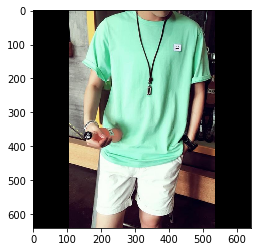

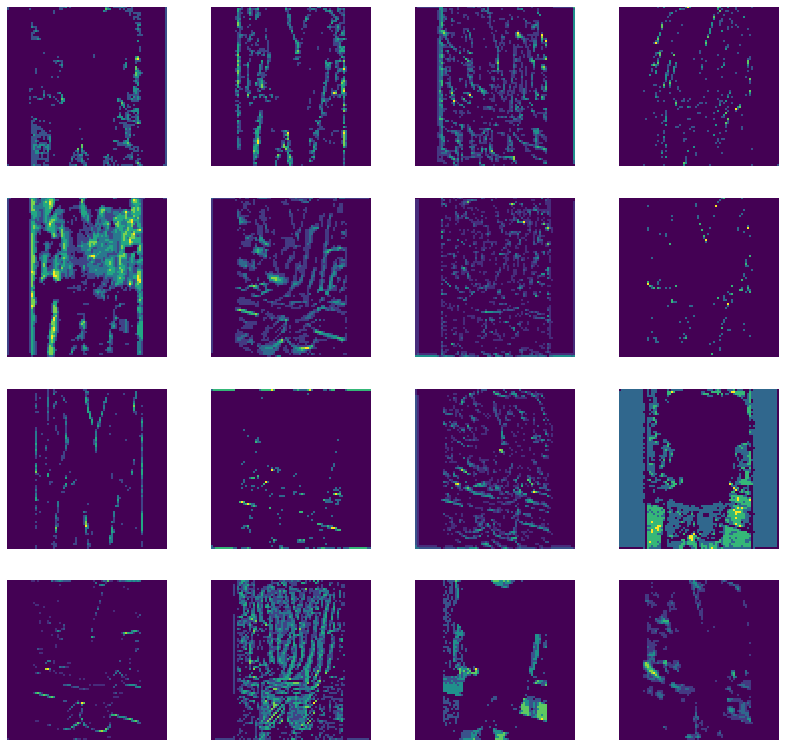

In [12]:
# Get activations of a few sample layers

# Select layer to visualize. Most play nicely with the backbone feature mapping, but not all.
layer_name = 'res3a_out'

activations = model.run_graph([image], [
    (layer_name,           model.keras_model.get_layer(layer_name).output),
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

# Show input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0], config))

# Show Backbone feature map
display_images(np.transpose(activations[layer_name][0,:,:,:16], [2, 0, 1]))

## Calculate Mask Average Precison (mAP)

In [13]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
import time
sample_size = 1

image_ids = np.random.choice(dataset_val.image_ids, sample_size)
APs = []

item = 0
start = time.time()
print("Calculating mAP on {} items".format(sample_size))
for image_id in image_ids:
    if(item % 10 == 0):
        end = time.time()
        print("{} percent done".format(100*item/sample_size))
        print("{} seconds per item".format((end-start)/10))
        start = time.time()
    item = item+1
    #Load image and ground truth data
    image_org, image_meta, gt_class_id, gt_bbox, gt_mask, gt_landmark =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

    molded_images = np.expand_dims(modellib.mold_image(image_org, inference_config), 0)
    # Run object detection
    results = model.detect([image_org], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

Calculating mAP on 1 items
0.0 percent done
2.2816658020019532e-05 seconds per item
mAP:  1.0


## Compare Class Accuracy
### Setup data tables

In [15]:
import pandas as pd
import seaborn as sns
import ast

data = pd.read_csv('val_class_predictions.csv')
preds = data.drop(columns={'Unnamed: 0'})

data = pd.read_csv('val_gt.csv')
truth = data.drop(columns={'Unnamed: 0'})

#Convert the string representation of lists into actual lists
truth['as_list'] = truth.apply(lambda x: ast.literal_eval(x['gt']),axis=1)

#Add the number of clothes in each image for convenience 
truth['gt_item_count'] = truth.apply(lambda x: len(x['as_list']),axis=1)

#Join the lists
table = preds.join(truth)

#Check it
table.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,gt,as_list,gt_item_count
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,[12],[12],1
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.611961,0.000000,0.0,0.0,0.0,[12],[12],1
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.671467,0.0,0.0,0.0,[10],[10],1
3,0.0,0.997592,0.0,0.0,0.0,0.0,0.0,0.0,0.70817,0.000000,0.000000,0.0,0.0,0.0,"[8, 1]","[8, 1]",2
4,0.0,0.900597,0.0,0.0,0.0,0.0,0.0,0.0,0.99964,0.000000,0.000000,0.0,0.0,0.0,"[8, 2]","[8, 2]",2


### Single item detection
Some statistics when there is only one article of clothing in the image to detect, for simplicitys sake

In [16]:
# Get single-item images
single = table[table['gt_item_count'] == 1]

#Pick the items from the list, otherwise we can't use groupby
single['gt'] = single.apply(lambda x: x['as_list'][0],axis=1)

/home/vic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [17]:
# For each type of cloth, check what the network believes it to be on average
average_confidence = single.groupby('gt').mean().drop(columns = {'gt_item_count'})

#Use names instead of numbers for predictions
average_confidence.columns = dataset_val.class_names

#The BG column is useless
average_confidence = average_confidence.drop(columns="BG")

#Use names instead of numbers for gt_classes
average_confidence.index = average_confidence.columns.values

In [ ]:
#Visualize it
sns.set()
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(average_confidence, annot=True, ax = ax)
ax.set_ylim(len(average_confidence),0)
plt.show()

In [ ]:
print("Number of items in each class")
fix, ax = plt.subplots(figsize = (15,10))
counts = single.groupby('gt').count()[['gt_item_count']]
counts.index = average_confidence.columns.values

sns.barplot(x=counts.index, y = counts.gt_item_count)
plt.xticks(rotation=45)
plt.show()